In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import random
import math

import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

from vision_data_engine.utils.general import get_class_names
from vision_data_engine.utils.similarity import get_worst_performing_images
from vision_data_engine.utils.visualization import plot_images_with_labels, create_imgs_with_labels

In [3]:
names = get_class_names("../yolov7/data/schreder.names")

In [4]:
model_eval_all = "/media/magalhaes/vision/test/yolov7_1681719082_best_schreder5"

model_weights = "/media/cache/magalhaes/vision/yolov7_1681719082/weights/best.pt"

In [6]:
TOP_N_WORST_IMAGES = 20

In [7]:
images_paths = get_worst_performing_images(model_eval_all, TOP_N_WORST_IMAGES, names, min_num_pred=0, ignore_classes=["emergency_vehicle"])

In [8]:
with open("./tmp_study.txt", "w") as fp:
    for path in images_paths:
        if "schreder" in path:
            fp.write(f"{path}\n")

In [12]:
images_with_label = create_imgs_with_labels(images_paths, names)

In [32]:
def get_imgs_predictions(weights_path=""):
    imgs = {}

    def load_classes(path):
        # Loads *.names file at 'path'
        with open(path, "r") as f:
            names = f.read().split("\n")
        return list(
            filter(None, names)
        )  # filter removes empty strings (such as last line)

    # Initialize
    device = torch.device("cuda:0")

    # Load model
    model = None
    if weights_path == "":
        model = Darknet("../yolo/models/yolov4-csp.cfg", 640).cuda()
        load_darknet_weights(
            model, "/media/magalhaes/vision/pretrained/yolov4-csp.weights"
        )
    else:
        model = Darknet("../yolo/models/yolov4-csp-schreder.cfg", 640).cuda()
        model.load_state_dict(torch.load(weights_path, map_location=device)["model"])
    model.to(device).eval()
    # if half:
    #     model.half()  # to FP16

    # Set Dataloader
    save_img = True
    dataset = LoadImages("./tmp_study.txt", img_size=640, auto_size=64)

    # Get names and colors
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

    # Run inference
    img = torch.zeros((1, 3, 640, 640), device=device)  # init img
    _ = model(img) if device.type != "cpu" else None  # run once

    for it, (path, img, im0s, vid_cap) in enumerate(dataset):
        img = torch.from_numpy(img).to(device)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        with torch.no_grad():
            # Inference
            pred = model(img, augment=False)[0]

            # Apply NMS
            pred = non_max_suppression(pred, 0.6, 0.6, classes=None, agnostic=False)

            # Process detections
            for i, det in enumerate(pred):  # detections per image
                p, s, im0 = path, "", im0s

                s += "%gx%g " % img.shape[2:]  # print string
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
                if det is not None and len(det):
                    # Rescale boxes from img_size to im0 size
                    det[:, :4] = scale_coords(
                        img.shape[2:], det[:, :4], im0.shape
                    ).round()

                    # Print results
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class
                        s += "%g %ss, " % (n, names[int(c)])  # add to string

                    # 480x640 -> 640x640
                    im0 = np.pad(im0, ((80, 80), (0, 0), (0, 0)))
                    # Write results
                    for *xyxy, conf, cls in det:
                        label = "%s %.2f" % (names[int(cls)], conf)
                        xyxy[1] += 80
                        xyxy[3] += 80

                        plot_one_box(
                            xyxy,
                            im0,
                            label=label,
                            color=colors[int(cls)],
                            line_thickness=3,
                        )
                else:
                    im0 = np.pad(im0, ((80, 80), (0, 0), (0, 0)))
                im0 = im0[:, :, ::-1]
                # Resize to im0 to 640 in largest dimension
                largest_dim_size = max(im0.shape[0], im0.shape[1])
                im0 = cv2.resize(
                    im0,
                    (
                        int((im0.shape[0] / largest_dim_size) * 640),
                        int((im0.shape[1] / largest_dim_size) * 640),
                    ),
                    interpolation=cv2.INTER_LINEAR,
                )
                imgs[f"{path.split('/')[-1]}"] = im0
    return imgs


In [33]:
# images_with_predictions = get_imgs_predictions("/media/magalhaes/vision/finetune_1670925131/weights/best.pt")
images_with_predictions = get_imgs_predictions(model_weights)

image 1/20 /home/guests2/msg/schreder/images/d1_13407_21195.jpg: image 2/20 /home/guests2/msg/schreder/images/d2_13507_2768.jpg: image 3/20 /home/guests2/msg/schreder/images/d2_15397_7308.jpg: image 4/20 /home/guests2/msg/schreder/images/d3_8304_1205.jpg: image 5/20 /home/guests2/msg/schreder/images/d3_8804_8097.jpg: image 6/20 /home/guests2/msg/schreder/images/d5_20049_9087.jpg: image 7/20 /home/guests2/msg/schreder/images/d5_31744_22959.jpg: image 8/20 /media/magalhaes/schreder/day_test_set/images/117_snapshot_20230103T143258183_3fbe.jpg: image 9/20 /media/magalhaes/schreder/day_test_set/images/134_snapshot_20230103T143258751_3f27.jpg: image 10/20 /media/magalhaes/schreder/day_test_set/images/177_snapshot_20230103T143300180_7e5d.jpg: image 11/20 /media/magalhaes/schreder/day_test_set/images/507_snapshot_20230103T143314384_f297.jpg: image 12/20 /media/magalhaes/schreder/night_test_set/images/loca201_20230109T201215863Z_1f97.jpg: image 13/20 /media/magalhaes/schreder/night_test_set/ima

In [17]:
def plot_comparison(img_dict_1, img_dict_2, n_columns=3):
    assert img_dict_1.keys() == img_dict_2.keys()
    n_images = len(img_dict_1)
    n_rows = math.ceil(n_images / n_columns)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(18, 3.75 * n_rows))

    missing = n_columns * n_rows
    for i, key in enumerate(img_dict_1.keys()):
        img_1 = img_dict_1[key]
        img_2 = img_dict_2[key]

        row = i // n_columns
        column = i % n_columns
        axs[row][column].imshow(np.hstack((img_1, img_2)))
        axs[row][column].set_title(key)
        axs[row][column].axis('off')
        missing -= 1
    for i in range(n_columns * n_rows - 1, n_columns * n_rows - 1 - missing, -1):
        row = i // n_columns
        column = i % n_columns
        axs[row][column].remove()

    return fig

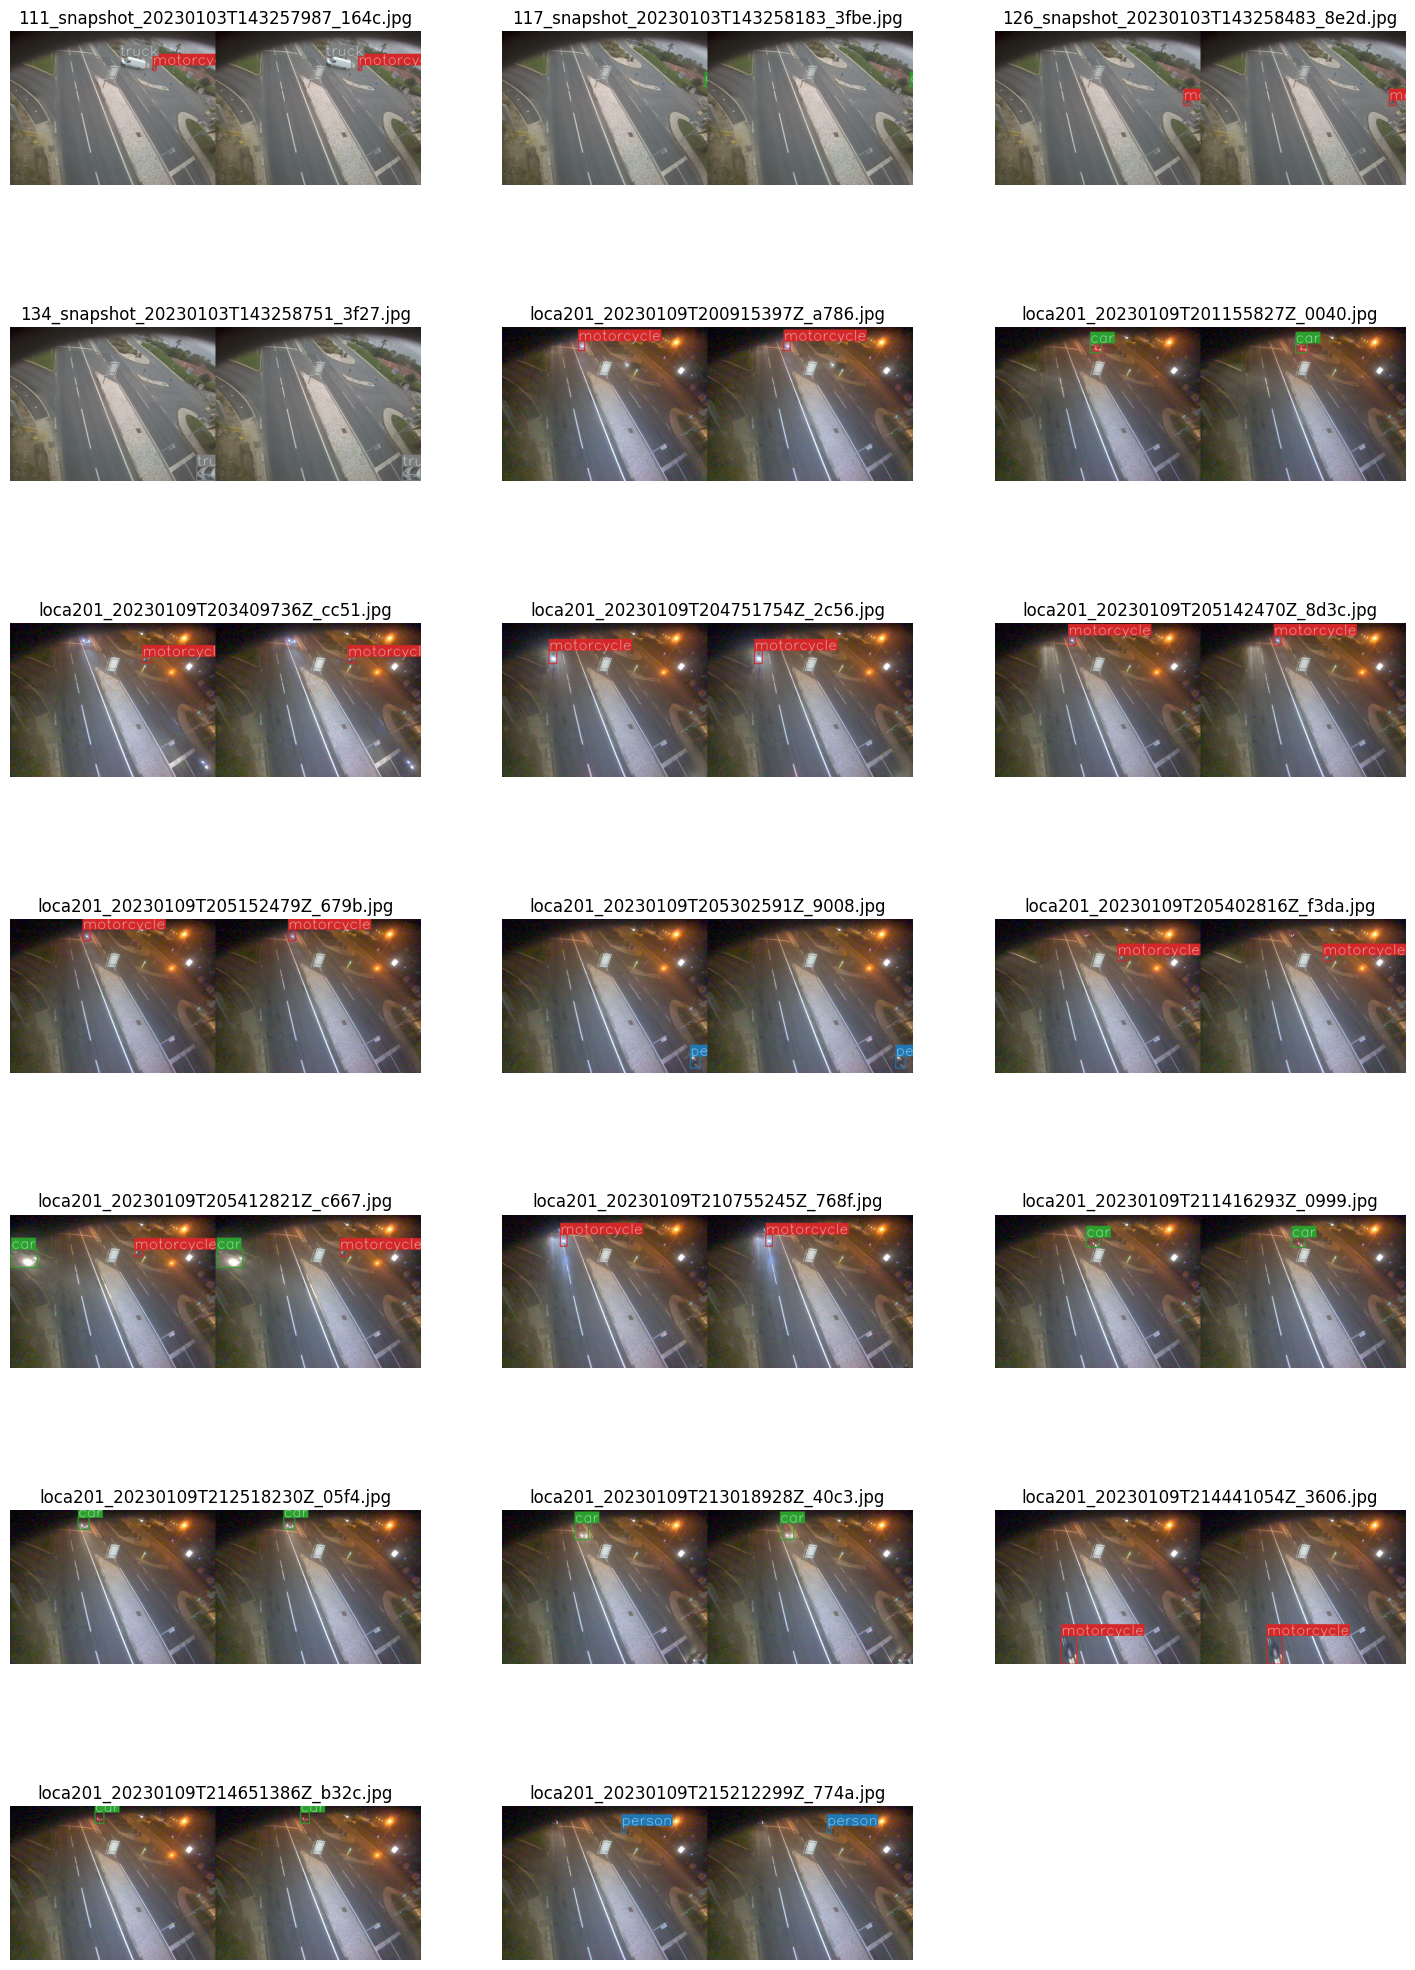

In [18]:
fig = plot_comparison(images_with_label, images_with_label)
fig.show()